# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
%pylab inline
from scipy import stats
import statsmodels.stats as smd
import seaborn as sns

np.random.seed(42)
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n

    return x, y

In [3]:
df = pd.read_csv('data/human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [4]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


#### 1. Is the distribution of body temperatures normal? 

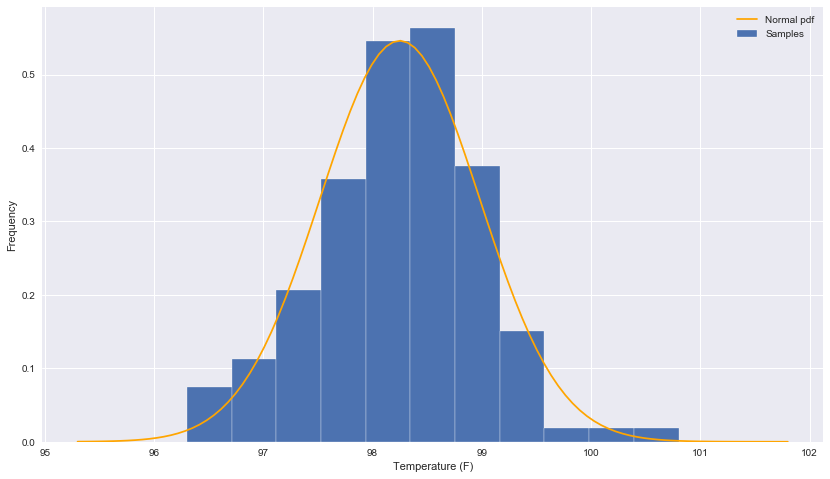

In [5]:
temp = df.temperature
figure(figsize = (14, 8))

nbins = int(np.sqrt(len(temp)))

_ = plt.hist(temp, density = True, bins = nbins, edgecolor = 'white')
k = np.linspace(np.min(temp) - 1, np.max(temp) + 1, 100, endpoint = True)
pdf = [stats.norm.pdf(_, loc = np.mean(temp), scale = np.std(temp)) for _ in k]
plot(k, pdf, '-', color = 'orange')

_ = xlabel('Temperature (F)')
_ = ylabel('Frequency')

margins = 0.02
leg = plt.legend(('Normal pdf', 'Samples'), frameon = False)
show()

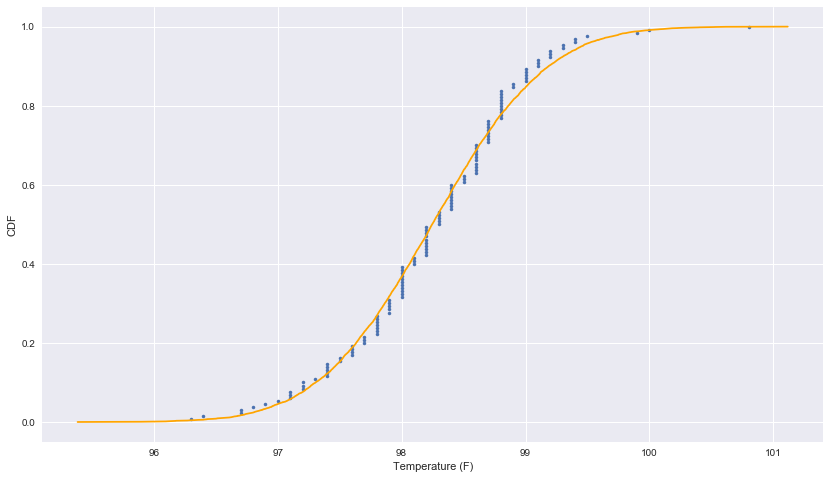

In [6]:
# Plot the CDFs
x, y = ecdf(temp)

# draw 10,000 random samples from a normal distribution
n_temp = np.random.normal(np.mean(temp), np.std(temp), 10000)
n_x, n_y = ecdf(n_temp)

figure(figsize = (14, 8))
_ = plot(x, y, marker = '.', linestyle = 'none')
_ = plot(n_x, n_y, color = 'orange')

_ = xlabel('Temperature (F)')
_ = ylabel('CDF')
margins = 0.02

In [7]:
stats.normaltest(temp)

NormaltestResult(statistic=2.703801433319203, pvalue=0.2587479863488254)

Visually, a histogram of temperature data show that the sample is normally distributed and is nearly symmetrical around the mean. Additionally, the p-value **0.259** is greater than the commonly-accepted significance level of 0.05, suggesting that we cannot reject the null hypothesis that the distribution is normal. 

#### 2. Is the sample size large? Are the observations independent? 

The Central Limit Theorem (CLT) states that **provided the sample size n is sufficiently large, then the sampling distribution of the sample mean bill be approximately normal regardless of the distribution of the underlying sample.** 
The necessary sample size n depends on the skewness of the distribution. 
The general rule of thumb is, **n > 30 yields an adequate approximation.**

The assumption of independence means that the outcome of one sample does not affect the outcome of another sample. This is satisfied because we're considering each sample's gender and temperature both individually and independently. 

In [8]:
n = len(df)
Male = df.temperature[df.gender == 'M']
Female = df.temperature[df.gender == 'F']

print('sample size:', n)
print('males:', len(Male))
print('females:', len(Female))

sample size: 130
males: 65
females: 65


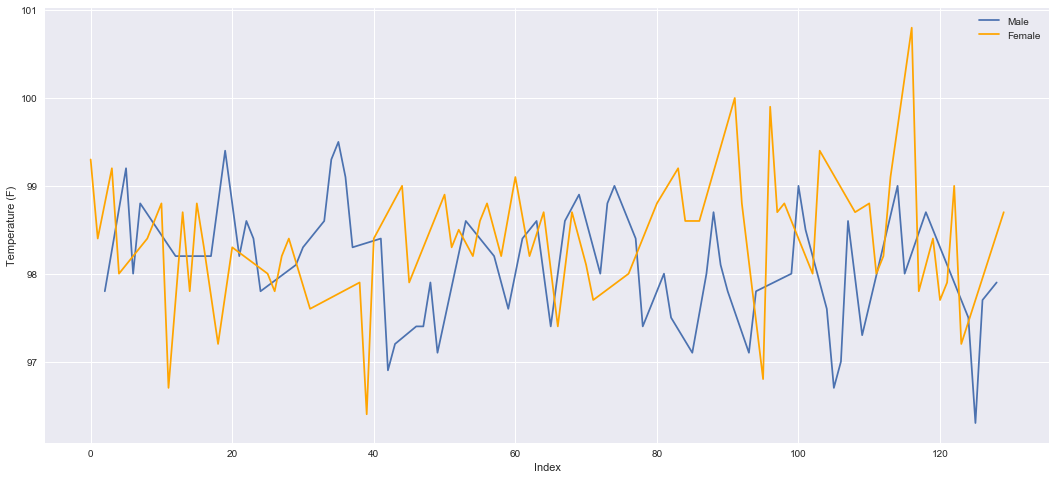

In [9]:
figure(figsize = (18, 8))
Male.plot(label = 'Male')
Female.plot(label = 'Female', color = 'orange')
xlabel('Index'); ylabel('Temperature (F)')
legend()

#### 3. Is the true population mean really 98.6 degrees F? 

    First, try a bootstrap hypothesis test.

In [10]:
# bootstrap hypothesis test drawing 10,000 samples
mean_s = temp.mean() # sample mean
std_s = temp.std()   # sample standard deviation
mean_p = 98.6 # the null hypothesis that mean population temperature is 98.6 

bs_replicates = np.empty(10000)

size = len(bs_replicates)

for i in range(size):
    bs_sample = np.random.choice(temp, len(temp))
    bs_replicates[i] = np.mean(bs_sample)

p = np.sum(bs_replicates >= mean_p) / size

print('p-value:', p)
print('mean: {:0.5}'.format(np.mean(bs_replicates)))

p-value: 0.0
mean: 98.25


From a bootstrap hypothesis test performed over 10,000 samples, we found the *p-value* to be (**0.0**) and mean population temperature to be **98.25** degrees F.  *p*(**0.0**) is less than the significance threshold ($\alpha$) of **0.05**, therefore we reject the null hypothesis that the true population mean temperature is 98.6 degrees F.

###### Frequentist statistical testing ######

    Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?

A one-sample t-test is appropriate for comparing a single sample mean to a known (in this case, hypothesised) mean of a population. Additionally, we would do a two-tailed test because we're interested in whether or not there is a statistically significant difference between the sample mean and the given true population mean (98.6 degrees F).  

    In this situation, is it appropriate to use the tt or zz statistic?
    Now try using the other test. How is the result be different? Why? 

</p> The z-statistic is useful for determining how far, in standard deviations, a data point is from the mean. Although the z-statistic can be helpful for testing hypotheses, they assume the sample size should be greater than 30 and are generally more useful when the standard deviation is known. </p>

$$z-test = \frac{\bar x - \mu}{{\sigma}/{\sqrt n}}$$

</p> $\bar x$ is the sample mean, $\sigma$ is the population standard deviation, n is the sample size, and $\mu$ is the population mean. </p>

</p> Because we were not given a population standard deviation, we can not proceed with the z-statistic. </p>



###### T-test

</p> The t-statistic, on the other hand, is most useful for determining if there is a statistically significant difference between the means of two sets of data when the standard deviation is not known. </p>

$$t-test = \frac{\bar x - \mu}{{s}/{\sqrt n}}$$

</p> In this situation, the t-statistic is most appropriate. </p>

In [11]:
ttest = stats.ttest_1samp(temp, mean_p, axis = 0)
print('t-score : {:0.4}\np-value: {:0.2}'.format(ttest.statistic, ttest.pvalue))

t-score : -5.455
p-value: 2.4e-07


*p* (2.4e-7) < $\alpha$.

#### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

    Which one is the correct one to use?
    What do you notice? What does this tell you about the difference in application of the tt and zz statistic? 


Because we do not know the standard deviation of the sample population, we proceed with the t-statistic.  

In [12]:
temp_10 = np.random.choice(temp, size = 10)
ttest_10 = stats.ttest_1samp(temp_10, mean_p)
print('t-score: {:0.4}\np-value: {:0.4}'.format(ttest_10.statistic, ttest_10.pvalue))

t-score: -1.361
p-value: 0.2068


Upon changing sample size from 10,000 to 10, we find that the p-value is not less than $\alpha$ **(0.05)**. Thus, we cannot reject the null hypothesis that the mean population temperature is 98.6 degrees F. 

#### 5. At what temperature should we consider someone's temperature to be "abnormal"?

    As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    
    Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws. 

In [13]:
print('sample mean: {:0.4}'.format(mean_s))
print('sample standard deviation: {:0.4}'.format(std_s))

sample mean: 98.25
sample standard deviation: 0.7332


###### bootstrap approach

In [39]:
# Draw 10,000 bootstrap replicates from the data and compute p-value
bs_replicates = np.empty(10000) # Initiate empty array

size = len(bs_replicates)
for i in range(size):
    bs_sample = np.random.choice(temp, size = len(temp))
    bs_replicates[i] = np.mean(bs_sample)

p = np.sum(bs_replicates >= mean_p) / len(bs_replicates)
print('p-value: {:0.4}'.format(p))

mean_bs = bs_replicates.mean()
ci = stats.norm.interval(0.95, loc = mean_bs, scale = std_s)

print('95% confidence interval: {:0.5} - {:0.5}'.format(ci[0], ci[1]))
print('margin of error: +/- {:0.5}\n\n'.format((ci[1] - mean_bs)))

p-value: 0.0
95% confidence interval: 96.812 - 99.686
margin of error: +/- 1.437




###### frequentist approach

In [15]:
ci_f_lo, ci_f_hi = stats.norm.interval(0.95, loc = mean_s, scale = std_s)
print('95% confidence interval: {:0.5} - {:0.5}'.format(ci_f_lo, ci_f_hi))
print('margin of error: +/- {:0.5}\n\n'.format((ci_f_hi - mean_s)))

95% confidence interval: 96.812 - 99.686
margin of error: +/- 1.437




Both approaches suggest, with 95% confidence, that a body temperature reading outside the range of **96.81 - 99.69 degrees F** is considered abnormal.

#### 6. Is there a significant difference between males and females in normal temperature?

    What testing approach did you use and why?
    Write a story with your conclusion in the context of the original problem. 


</p>Null hypothesis: The normal temperature of males and females are the same.</p>

</p>$H_o: \bar x_m\ =\ \bar x_f$ </p>

</p>Alternate hypothesis: The normal temperature of males and females are not the same. </p>

</p>$H_a: \bar x_m \neq\ \bar x_f$</p>

In [36]:
df.groupby('gender')['temperature'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,65.0,98.393846,0.743488,96.4,98.0,98.4,98.8,100.8
M,65.0,98.104615,0.698756,96.3,97.6,98.1,98.6,99.5


The normal male temperature is approximately 0.3 degrees less than the normal female temperature. Is this difference statistically significant? ... let's explore!

Text(0,0.5,'Frequency')

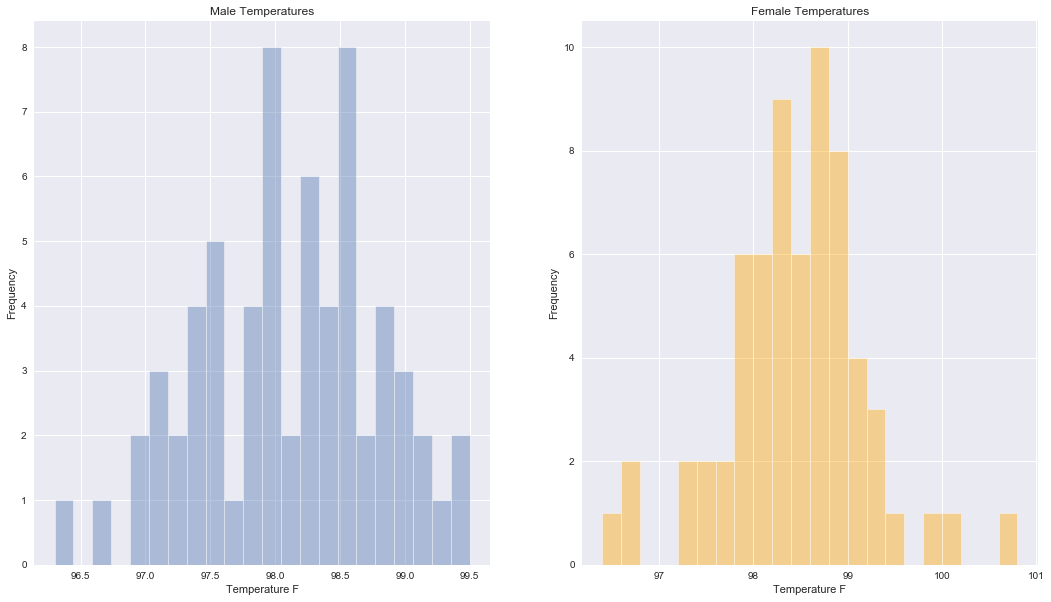

In [25]:
f, (ax1, ax2) = subplots(1, 2, figsize = (18,10))
sns.distplot(Male, kde = False, bins = nbins*2, ax = ax1, hist_kws = dict(edgecolor = 'white', linewidth = 1))
sns.distplot(Female, kde = False, bins = nbins*2, ax = ax2, color = 'orange', hist_kws = dict(edgecolor = 'white', linewidth = 1))

ax1.set_title('Male Temperatures')
ax1.set_xlabel('Temperature F') 
ax1.set_ylabel('Frequency')

ax2.set_title('Female Temperatures')
ax2.set_xlabel('Temperature F')
ax2.set_ylabel('Frequency')

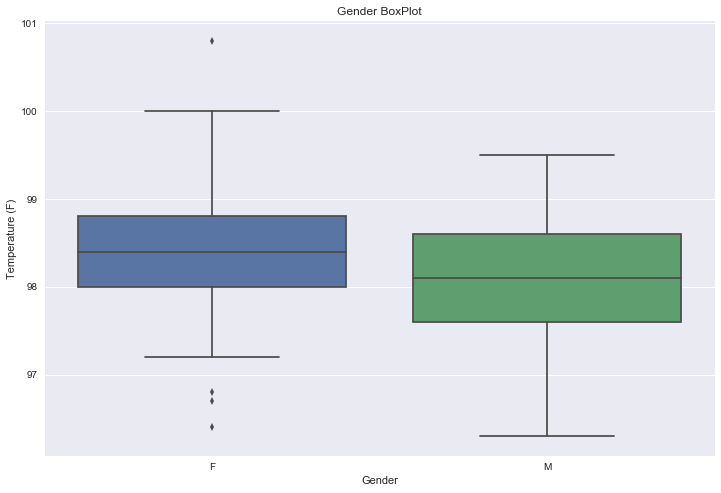

In [37]:
figure(figsize(12,8))
sns.boxplot(x = 'gender', y = 'temperature', data = df)
_ = xlabel('Gender')
_ = ylabel('Temperature (F)')
_ = title('Gender BoxPlot')
show()

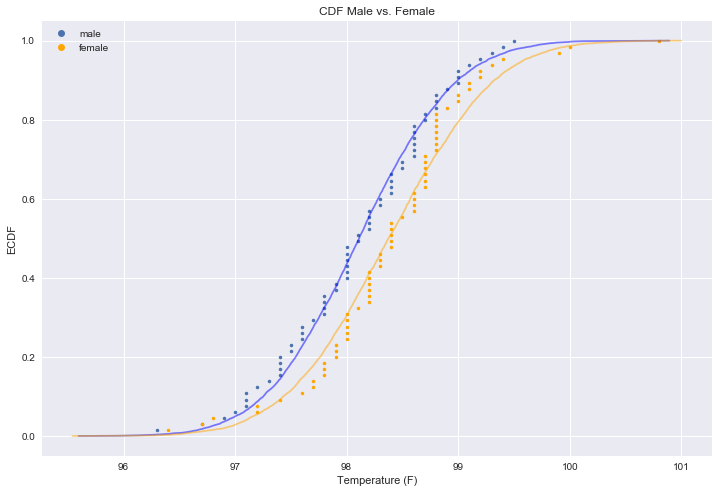

In [38]:
# Compute ECDFs for Male and Female
x_m, y_m = ecdf(Male)
x_f, y_f = ecdf(Female)

plt.plot(x_m, y_m, marker = '.', linestyle = 'none')
plt.plot(x_f, y_f, marker = '.', linestyle = 'none', color = 'orange')

# Draw 10,000 random samples from a normal distribution
m_nd = np.random.normal(np.mean(Male), np.std(Male), 10000)
x_mnd, y_mnd = ecdf(m_nd)
_ = plt.plot(x_mnd, y_mnd, color = 'blue', alpha = 0.5)

# Draw 10,000 random samples from a normal distribution
f_nd = np.random.normal(np.mean(Female), np.std(Female), 10000)
x_fnd, y_fnd = ecdf(f_nd)
_ = plt.plot(x_fnd, y_fnd, color = 'orange', alpha = 0.5)

margins = 0.02

_ = xlabel('Temperature (F)')
_ = ylabel('ECDF')
_ = title('CDF Male vs. Female')
_ = legend(('male', 'female'), markerscale = 2)

show()

In [49]:
# Comparing variances
m_var = np.var(Male)
f_var = np.var(Female)

print('Male variance: {:0.5}\nFemale variance: {:0.5}'.format(m_var, f_var))

Male variance: 0.48075
Female variance: 0.54427


</p> We can see that female body temperatures have a larger spread (histogram), greater variation (boxplot), and typically warmer temperatures (CDF) compared to male body temperatures. </p>

</p> We proceed with a two-tailed Welch's t-test to determine whether the difference in male and female body temperatures is statistically significant by considering either gender as independent samples. Welch's t-test, as opposed to the Student's t-test, is considered more reliable when the samples have unequal variances.</p>

In [47]:
# Draw 10,000 bootstrap replicates from the data and computes p-value
size = 10000

m_bsreps = np.empty(size) # initiate bootstrap replicates for both genders
for i in range(size):
    m_sample = np.random.choice(Male, len(Male))
    m_bsreps[i] = np.mean(m_sample)
    
m_mean = np.sum(m_bsreps)/size

f_bsreps = np.empty(size)
for i in range(size):
    f_sample = np.random.choice(Female, len(Female))
    f_bsreps[i] = np.mean(f_sample)
    
f_mean = np.sum(f_bsreps)/size


ttest = stats.ttest_ind(f_bsreps, m_bsreps, axis = 0, equal_var = False)

print('t-statistic: {:0.5}\np-value: {}'.format(ttest[0], ttest[1]))

t-statistic: 228.45
p-value: 0.0


Upon performing a Welch's t-test on the male and female groups, we find a **p-value** of **0.0** which is less than $\alpha$. Thus, we reject the null hypothesis that the normal male and female temperatures are equal and we have evidence in support of the alternate hypothesis that the difference in normal temperature between genders is statistically significant. 

##### Conclusion #####

Contrary to the century-old belief that the normal human body temperature is 98.6$^{\circ}$F, we found evidence suggesting that the statistically correct normal body temperature is 98.25$^{\circ}$F. The difference between the mean population body temperature and the mean of our sample was statistically significant, where *p-value (0.0)* < $\alpha$(0.05), thus we reject the null hypothesis that the normal body temperature is 98.6$^{\circ}$F. This new mean body temperature was then used to compute a range for which the human body temperature can be considered normal (96.81 - 99.69$^{\circ}$F), with 95% confidence. Lastly, we performed a gender body temperature comparison study and found a statistically significant difference between female (98.39$^{\circ}$F) and male (98.10$^{\circ}$F) normal body temperatures. 